# Data Visualization 100 events


In [44]:
import uproot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from collections import namedtuple, defaultdict
import open3d as o3d
import random
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import awkward as ak

In [45]:
uproot.__version__

'5.0.9'

### Command to generate such event
#### using athena/main/latest release
Reco_tf.py --outputRDO_TRIGFile=/eos/user/d/dbakshig/CaloCellInfo/RDO_TRIG_3.pool.root --preExec "all:setMenu='Dev_pp_run3_v1_TriggerValidation_prescale';ConfigFlags.Trigger.AODEDMSet='AODFULL';ConfigFlags.Trigger.ExtraEDMList=[['CaloClusterCellLinkContainer#HLT_TopoCaloClustersFS_links',  'BS ESD AODCOMM', 'Calo'], ['CaloCellContainer#CaloCellsFS',  'BS ESD AODCOMM', 'Calo'],['xAOD::CaloClusterTrigAuxContainer#HLT_TopoCaloClustersFSAux.CellLink', 'BS ESD AODCOMM', 'Calo']];" "RDOtoRDOTrigger:fpeAuditor=True;" --athenaopts="--imf --threads=1" --maxEvents=1000 --inputRDOFile=/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/TriggerTest/valid1.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.recon.RDO.e8453_e8455_s3873_s3874_r13829_tid30652137_00/RDO.30652137._000009.pool.root.1,/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/TriggerTest/valid1.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.recon.RDO.e8453_e8455_s3873_s3874_r13829_tid30652137_00/RDO.30652137._000010.pool.root.1 >& /eos/user/d/dbakshig/CaloCellInfo/caloCellInfo_3.log

#### The above Reco_tf.py uses RDO files as inputs , with *e8453_e8455_s3873_s3874_r13829* tags (info: https://atlas-ami.cern.ch/?subapp=tagsShow&userdata=e8453_e8455_s3864_d1761_d1758)

In [46]:
!ls ..

CaloGNN.png
GNNKeras.ipynb
LLP_for_Calo.ipynb
LLP_time-Copy1.ipynb
LLP_time.ipynb
LLP_time_1.ipynb
MLBasedCaloClustering
MLBasedCaloClusteringPipeLine
ML_01.ipynb
ML_Cell_data
ML_for_Calo.ipynb
ML_for_Calo_students.ipynb
MyxAODAnalysis_100evnts.outputs.root
MyxAODAnalysis_100evnts_old.outputs.root
Untitled.ipynb
ZacClub.ipynb
debottam@237.93.105.92
fixed_length.py
input.txt
karate.edgelist
mlp-0000.params
mlp-symbol.json
mxHybrid.ipynb
mxnet_exported_mlp.onnx
my_env
saved_model
trackML.ipynb


In [47]:
file = uproot.open("../MyxAODAnalysis_100evnts.outputs.root")

In [48]:
file.keys()

['analysis;1']

In [49]:
tree = file['analysis']

In [50]:
tree.keys() # no. of variables per event

['RunNumber',
 'EventNumber',
 'cell_eta',
 'cell_phi',
 'cell_x',
 'cell_y',
 'cell_z',
 'cell_subCalo',
 'cell_sampling',
 'cell_size',
 'cell_e',
 'cell_noiseSigma',
 'cell_SNR',
 'cell_time',
 'cell_weight',
 'cell_truth',
 'cell_truth_indices',
 'cell_shared_indices',
 'cell_cluster_index',
 'cluster_to_cell_indices',
 'cluster_to_cell_weights',
 'cell_to_cluster_e',
 'cell_to_cluster_eta',
 'cell_to_cluster_phi',
 'cluster_eta',
 'cluster_phi',
 'cluster_e',
 'cellsNo_cluster',
 'clustersNo_event',
 'jet_energyWtdTimeAve']

In [51]:
branches = tree.arrays()

In [39]:
## No. of cell per event
cellsInCalorimeter = len( branches['cell_e'][0])
print("no. of cells in Calorimeter: ", cellsInCalorimeter)

no. of cells in Calorimeter:  187652


# Description of data set:
We decided to use following features from an event
### Geometric features:

##### 1. cell_coordinate_x (mm)
##### 2. cell_coordinate_y (mm)
##### 3. cell_coordinate_z (mm)
##### 4. cell_subCalo          : LAREM = 0, LARHEC = 1, LARFCAL = 2, TILE = 3, LARMINIFCAL = 4, NSUBCALO = 5,
##### 5. cell_sampling         : More granular information of the subcalo above

### Deposited energy related features:

##### 6. cell_SNR          : signal to noise ratio of a cell
##### 7. cell_e               : Energy deposited in a cell in MeV

### Topocluster related cell features:

##### 8. cell_truth             : 0/1 whether cell takes part in a cluster or not
##### 9. cell_weight            : could have more than 1 entry (value 0 to 1) but using the max weight for simplicity
##### 10. cell_to_cluster_index  : index/id of the cluster where the cell has maximum weight (again for initial study)
##### 11. cell_to_cluster_e      : energy of the cluster where the cell has maximum weight (again for initial study)

# Visualization of cell geometry

### A. Y-Z coordinates (Tile cells are in red)

Text(0, 0.5, 'y direction (mm)')

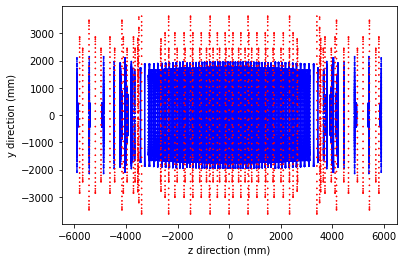

In [40]:
s = 1
col = np.where(cell_subCalo==3,'r','b')
plt.scatter(cell_coordinate_z, cell_coordinate_y, marker='.', s=s, c=col)
plt.xlabel("z direction (mm)")
plt.ylabel("y direction (mm)")

### B. X-Y coordinates (Tile cells are in red)

Text(0, 0.5, 'y direction (mm)')

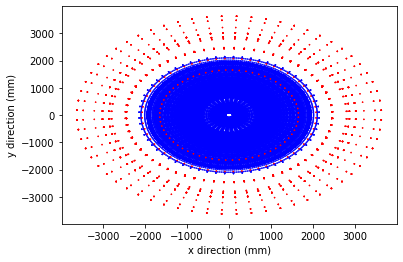

In [41]:
plt.scatter(cell_coordinate_x, cell_coordinate_y, marker='.', s=s, c=col)
plt.xlabel("x direction (mm)")
plt.ylabel("y direction (mm)")

## Visualization of the features (partcipating cells + non participating cells)

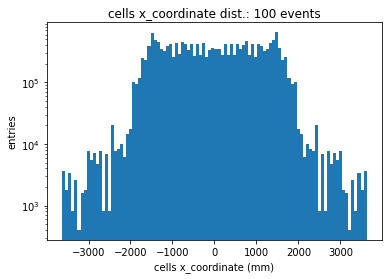

In [53]:
plt.hist(ak.flatten(branches['cell_x']), bins = 100)
plt.title("cells x_coordinate dist.: 100 events")
plt.xlabel("cells x_coordinate (mm)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

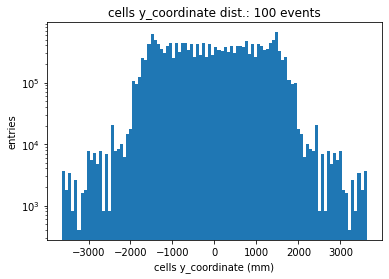

In [54]:
plt.hist(ak.flatten(branches['cell_y']), bins = 100)
plt.title("cells y_coordinate dist.: 100 events")
plt.xlabel("cells y_coordinate (mm)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

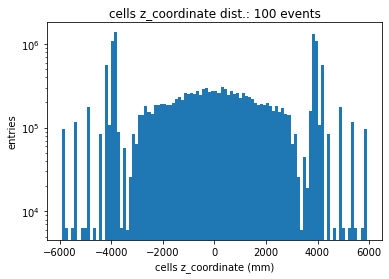

In [55]:
plt.hist(ak.flatten(branches['cell_z']), bins = 100)
plt.title("cells z_coordinate dist.: 100 events")
plt.xlabel("cells z_coordinate (mm)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

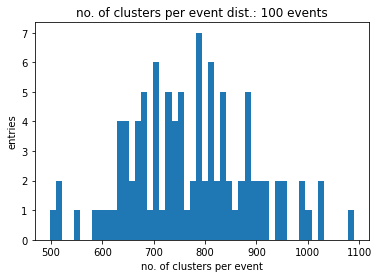

In [100]:
plt.hist(branches['clustersNo_event'], bins = 50)
plt.title("no. of clusters per event dist.: 100 events")
plt.xlabel("no. of clusters per event")
plt.ylabel("entries")
#plt.yscale("log")
plt.show()

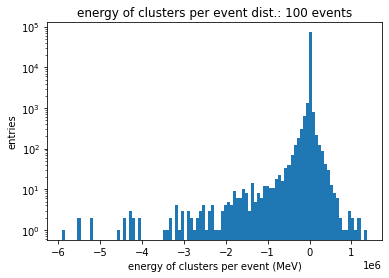

In [101]:
plt.hist(ak.flatten(branches['cluster_e']), bins = 100)
plt.title("energy of clusters per event dist.: 100 events")
plt.xlabel("energy of clusters per event (MeV)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

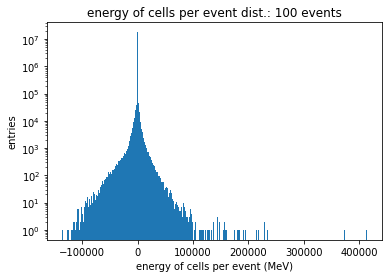

In [102]:
plt.hist(ak.flatten(branches['cell_e']), bins = 500)
plt.title("energy of cells per event dist.: 100 events")
plt.xlabel("energy of cells per event (MeV)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

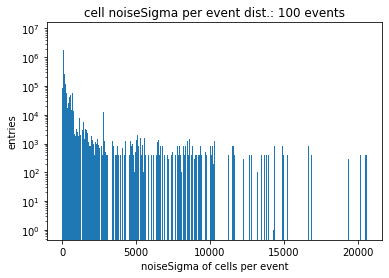

In [103]:
plt.hist(ak.flatten(branches['cell_noiseSigma']), bins = 1000)
plt.title("cell noiseSigma per event dist.: 100 events")
plt.xlabel("noiseSigma of cells per event")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

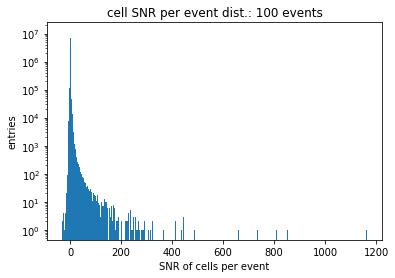

In [104]:
plt.hist(ak.flatten(branches['cell_SNR']), bins = 500)
plt.title("cell SNR per event dist.: 100 events")
plt.xlabel("SNR of cells per event")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

##  Only Participating cell for 100 events

In [106]:
participatingCell_percentage = []
for cell in branches['cell_truth_indices']:
    truthPercent = (len(cell)/cellsInCalorimeter)*100
    participatingCell_percentage.append(truthPercent)

bin_count:  16


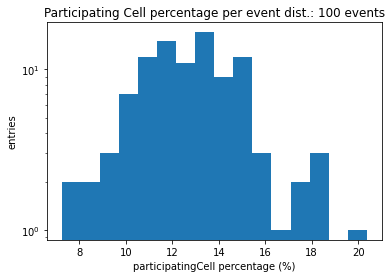

In [172]:
q1, q3 = np.percentile(participatingCell_percentage, 25), np.percentile(participatingCell_percentage, 75)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(participatingCell_percentage) ** (1 / 3))
bin_count = int(np.ceil((max(participatingCell_percentage) - min(participatingCell_percentage) / bin_width)))
print("bin_count: ",bin_count)
plt.hist(participatingCell_percentage, bin_count)
plt.title("Participating Cell percentage per event dist.: 100 events")
plt.xlabel("participatingCell percentage (%)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

In [56]:
participatingCell_x = []
participatingCell_y = []
participatingCell_z = []
for i in range(len(branches['cell_truth_indices'])):
    cell_x = np.array(branches['cell_x'][i])
    cell_y = np.array(branches['cell_y'][i])
    cell_z = np.array(branches['cell_z'][i])
    participating_x = cell_x[branches['cell_truth_indices'][i]]
    participating_y = cell_y[branches['cell_truth_indices'][i]]
    participating_z = cell_z[branches['cell_truth_indices'][i]]
    participatingCell_x.append(participating_x)
    participatingCell_y.append(participating_y)
    participatingCell_z.append(participating_z)

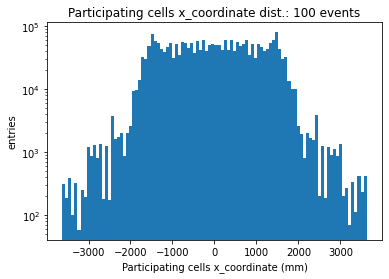

In [57]:
plt.hist(ak.flatten(participatingCell_x), bins = 100)
plt.title("Participating cells x_coordinate dist.: 100 events")
plt.xlabel("Participating cells x_coordinate (mm)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

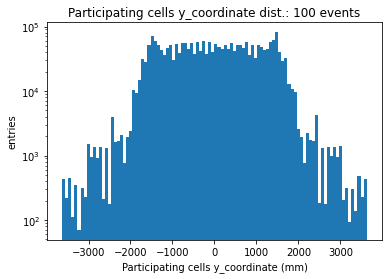

In [58]:
plt.hist(ak.flatten(participatingCell_y), bins = 100)
plt.title("Participating cells y_coordinate dist.: 100 events")
plt.xlabel("Participating cells y_coordinate (mm)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

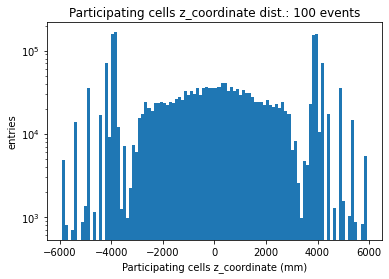

In [59]:
plt.hist(ak.flatten(participatingCell_z), bins = 100)
plt.title("Participating cells z_coordinate dist.: 100 events")
plt.xlabel("Participating cells z_coordinate (mm)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

In [170]:
participatingCell_SNR = []
nan_SNR_percentage = []
for i in range(len(branches['cell_truth_indices'])):
    cell_SNR = np.array(branches['cell_SNR'][i])
    participating_event = cell_SNR[branches['cell_truth_indices'][i]]
    participatingCell_SNR.append(participating_event)
    bool_SNR = np.isnan(cell_SNR)
    nanIndex = np.where(bool_SNR==True)
    nan_SNR_event = (len(nanIndex[0])/cellsInCalorimeter)*100
    nan_SNR_percentage.append(nan_SNR_event)

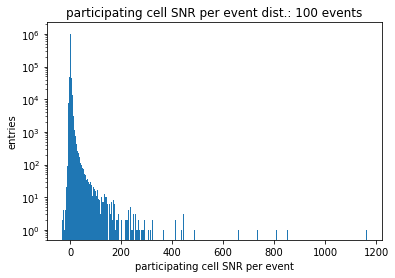

In [147]:
plt.hist(ak.flatten(participatingCell_SNR), bins = 500)
plt.title("participating cell SNR per event dist.: 100 events")
plt.xlabel("participating cell SNR per event")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

In [159]:
participatingCell_e = []
for i in range(len(branches['cell_truth_indices'])):
    cell_e = np.array(branches['cell_e'][i])
    participating_event = cell_e[branches['cell_truth_indices'][i]]
    #print(len(participating_event))
    participatingCell_e.append(participating_event)

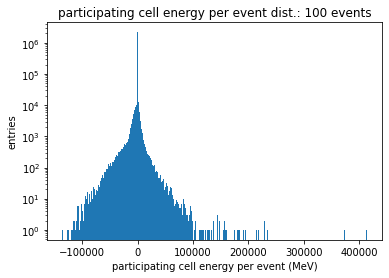

In [171]:
plt.hist(ak.flatten(participatingCell_e), bins = 500)
plt.title("participating cell energy per event dist.: 100 events")
plt.xlabel("participating cell energy per event (MeV)")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

In [173]:
participatingCell_noise = []
for i in range(len(branches['cell_truth_indices'])):
    cell_noiseSigma = np.array(branches['cell_noiseSigma'][i])
    participating_event = cell_noiseSigma[branches['cell_truth_indices'][i]]
    participatingCell_noise.append(participating_event)

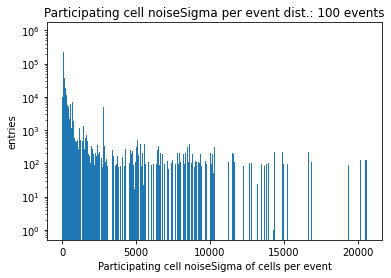

In [174]:
plt.hist(ak.flatten(participatingCell_noise), bins = 1000)
plt.title("Participating cell noiseSigma per event dist.: 100 events")
plt.xlabel("Participating cell noiseSigma of cells per event")
plt.ylabel("entries")
plt.yscale("log")
plt.show()

In [175]:
participatingCell_subCalo = []
for i in range(len(branches['cell_truth_indices'])):
    cell_subCalo = np.array(branches['cell_subCalo'][i])
    participating_event = cell_subCalo[branches['cell_truth_indices'][i]]
    participatingCell_subCalo.append(participating_event)

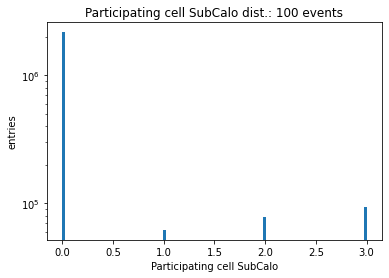

In [176]:
#LAREM = 0, LARHEC = 1, LARFCAL = 2, TILE = 3, LARMINIFCAL = 4, NSUBCALO = 5,
plt.hist(ak.flatten(participatingCell_subCalo), bins = 100)
plt.title("Participating cell SubCalo dist.: 100 events")
plt.xlabel("Participating cell SubCalo")
plt.yscale("log")
plt.ylabel("entries")
plt.show()

In [32]:
participatingCell_sampling = []
for i in range(len(branches['cell_truth_indices'])):
    cell_sampling = np.array(branches['cell_sampling'][i])
    participating_event = cell_sampling[branches['cell_truth_indices'][i]]
    participatingCell_sampling.append(participating_event)

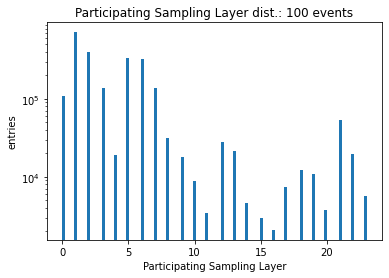

In [34]:
plt.hist(ak.flatten(participatingCell_sampling), bins = 100)
plt.title("Participating Sampling Layer dist.: 100 events")
plt.xlabel("Participating Sampling Layer")
plt.yscale("log")
plt.ylabel("entries")
plt.show()

In [35]:
shared_cell_percentage = []
for cell in branches['cell_shared_indices']:
    percentage_event = (len(cell)/cellsInCalorimeter)*100
    shared_cell_percentage.append(percentage_event)

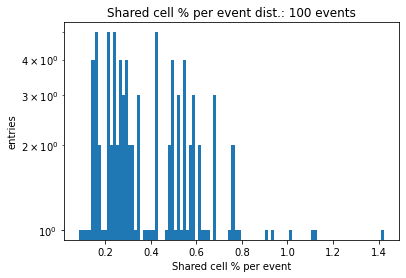

In [36]:
plt.hist(shared_cell_percentage, bins = 100)
plt.title("Shared cell % per event dist.: 100 events")
plt.xlabel("Shared cell % per event")
plt.yscale("log")
plt.ylabel("entries")
plt.show()